In [43]:
#from envs.LinearBertrandInflation_final3 import LinearBertrandEnv
from envs.LinearBertrandInflation import LinearBertrandEnv
from envs.BertrandInflation import BertrandEnv
from agents.sac import SACAgent
from replay_buffer import ReplayBuffer
from tqdm import tqdm
import numpy as np

N = 2
k = 10
rho = 1e-4
#total_timesteps = 30_000
total_timesteps = 500_000
episodes = 1
inflation_start = 0
deviate_start = 0.85
deviate_end = 0.95

#env = LinearBertrandEnv(N = N, k = k, rho = rho, v = int(k * 1.5), timesteps = total_timesteps, moving_dim = 200, use_moving_avg=True, inflation_start=inflation_start, max_var = 2.0)
env = BertrandEnv(N = N, k = k, rho = rho, v = int(k * 1.5), timesteps = total_timesteps, 
                  use_moving_avg=True, inflation_start=inflation_start, max_var = 2.0)
dim_states = N * k + k + 1
agents = [SACAgent(dim_states, 1, gamma=0.95, actor_lr=3e-4, Q_lr=3e-4, alpha_lr=3e-4) for agent in range(env.N)]

buffer = ReplayBuffer(dim_states=dim_states, N = env.N, sample_size = 512, buffer_size = 1_000_000)

prices_history = np.zeros((episodes, total_timesteps, N))
actions_history = np.zeros((episodes, total_timesteps, N))
costs_history = np.zeros((episodes, total_timesteps))
monopoly_history = np.zeros((episodes, total_timesteps))
nash_history = np.zeros((episodes, total_timesteps))
rewards_history = np.zeros((episodes, total_timesteps, N))
delta_history = np.zeros((episodes, total_timesteps))
quantities_history = np.zeros((episodes, total_timesteps, N))
pi_N_history = np.zeros((episodes, total_timesteps))
pi_M_history = np.zeros((episodes, total_timesteps))
A_history = np.zeros((episodes, total_timesteps))

for episode in range(episodes):
    ob_t = env.reset()
    for timestep in tqdm(range(total_timesteps)):
        
        actions = [agent.select_action(ob_t) for agent in agents]
        
        if (timestep/total_timesteps > deviate_start) and (timestep/total_timesteps <= deviate_end):
            env.trigger_deviation = True
        
        elif timestep/total_timesteps > deviate_end:
            env.trigger_deviation = False
        
        ob_t1, rewards, done, _ = env.step(actions)
        
        experience = (ob_t, actions, rewards, ob_t1, done)
        buffer.store_transition(*experience)
        
        if timestep > buffer.sample_size:
            for agent_idx in range(N):
                agent = agents[agent_idx]
                sample = buffer.sample(agent_idx)
                agent.update(*sample)
        
        ob_t = ob_t1
        
    # store metrics
    prices_history[episode] = np.array(env.prices_history)[-total_timesteps:]
    actions_history[episode] = np.array(env.action_history)[-total_timesteps:]
    costs_history[episode] = np.array(env.costs_history)[-total_timesteps:]
    monopoly_history[episode] = np.array(env.monopoly_history)[-total_timesteps:]
    nash_history[episode] = np.array(env.nash_history)[-total_timesteps:]
    rewards_history[episode] = np.array(env.rewards_history)[-total_timesteps:]
    delta_history[episode] = np.array(env.metric_history)[-total_timesteps:]
    quantities_history[episode] = np.array(env.quantities_history)[-total_timesteps:]
    pi_N_history[episode] = np.array(env.pi_N_history)[-total_timesteps:]
    pi_M_history[episode] = np.array(env.pi_M_history)[-total_timesteps:]
    A_history[episode] = np.array(env.A_history)[-total_timesteps:]
    
prices_history = np.mean(prices_history, axis = 0)
actions_history = np.mean(actions_history, axis = 0)
costs_history = np.mean(costs_history, axis = 0)
monopoly_history = np.mean(monopoly_history, axis = 0)
nash_history = np.mean(nash_history, axis = 0)
rewards_history = np.mean(rewards_history, axis = 0)
delta_history = np.mean(delta_history, axis = 0)
quantities_history = np.mean(quantities_history, axis = 0)
pi_N_history = np.mean(pi_N_history, axis = 0)
pi_M_history = np.mean(pi_M_history, axis = 0)
A_history = np.mean(A_history, axis = 0) # equal disposition to pay

100%|██████████| 500000/500000 [3:57:01<00:00, 35.16it/s]  


In [44]:
from utils.plot_metrics import get_rolling
import pandas as pd

## EXPORT
results = pd.DataFrame({'costs': costs_history,
                        'pi_N': pi_N_history,
                        'pi_M': pi_M_history,
                        'delta': delta_history,
                        'p_nash': nash_history,
                        'p_monopoly': monopoly_history,
                        'A': A_history,
                        })

for agent in range(env.N):
    results[f'actions_{agent}'] = actions_history[:, agent]
    results[f'prices_{agent}'] = prices_history[:, agent]
    results[f'quantities_{agent}'] = quantities_history[:, agent]
    results[f'rewards_{agent}'] = rewards_history[:, agent]
    
results.to_csv(f'test.csv', index = False, sep = ';', encoding = 'utf-8-sig')

## READ AND PREPARE
window_size = 1000
df_plot = pd.read_csv('test.csv', sep = ';', encoding = 'utf-8-sig')

actions_cols = [col for col in df_plot.columns if 'actions' in col]
price_cols = [col for col in df_plot.columns if 'prices' in col]
rewards_cols = [col for col in df_plot.columns if 'rewards' in col]
quantities_cols = [col for col in df_plot.columns if 'quantities' in col]

n_agents = len(actions_cols)

df_plot['avg_actions'] = df_plot[actions_cols].mean(axis = 1)
df_plot['avg_prices'] = df_plot[price_cols].mean(axis = 1)
df_plot['avg_rewards'] = df_plot[rewards_cols].mean(axis = 1)
df_plot['avg_quantities'] = df_plot[quantities_cols].mean(axis = 1)
avg_cols = [col for col in df_plot.columns if 'avg' in col]

window_cols = price_cols + rewards_cols + quantities_cols + avg_cols + ['delta']
for col in window_cols:
    df_plot[col] = get_rolling(df_plot[col], window_size = window_size)

df_plot.tail()

,costs,pi_N,pi_M,delta,p_nash,p_monopoly,A,actions_0,prices_0,quantities_0,rewards_0,actions_1,prices_1,quantities_1,rewards_1,avg_actions,avg_prices,avg_rewards,avg_quantities
499995,1.988429,0.299471,0.343706,-2.180356,2.7879,3.175841,2.988429,0.349000,3.473206,0.261150,0.202496,-0.006257,3.443050,0.280033,0.203551,0.360148,3.458128,0.203024,0.270591
499996,1.988429,0.299471,0.343706,-2.185675,2.7879,3.175841,2.988429,0.012207,3.471453,0.261647,0.202371,0.083163,3.442456,0.279872,0.203206,0.359852,3.456954,0.202788,0.270759
499997,1.988429,0.299471,0.343706,-2.187512,2.7879,3.175841,2.988429,0.152663,3.470978,0.261917,0.202364,0.411549,3.442749,0.279739,0.203050,0.359830,3.456863,0.202707,0.270828
499998,1.988429,0.299471,0.343706,-2.191116,2.7879,3.175841,2.988429,0.203292,3.470681,0.261675,0.202042,0.038304,3.440677,0.280382,0.203054,0.359532,3.455679,0.202548,0.271029
499999,1.988429,0.299471,0.343706,-2.190744,2.7879,3.175841,2.988429,0.291005,3.469595,0.262021,0.202387,0.521784,3.441478,0.280097,0.202741,0.359496,3.455536,0.202564,0.271059


In [ ]:
# ahora solo queda productivizar el trigger_deviate y obtener resultados!

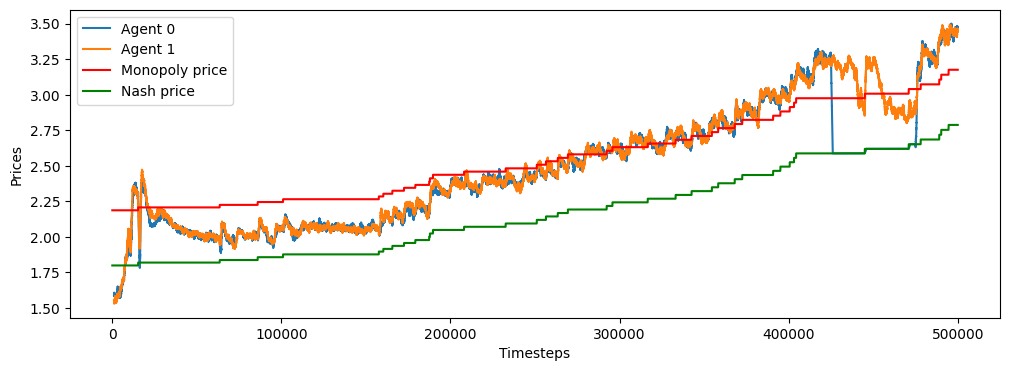

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 4))
for agent in range(n_agents):
    price_serie = df_plot[f'prices_{agent}']
    plt.plot(price_serie, label = f'Agent {agent}')
plt.plot(df_plot['p_monopoly'], color = 'red', label = 'Monopoly price')
plt.plot(df_plot['p_nash'], color = 'green', label = 'Nash price')
plt.xlabel('Timesteps')
plt.ylabel('Prices')
plt.legend()
plt.savefig('plot.png')

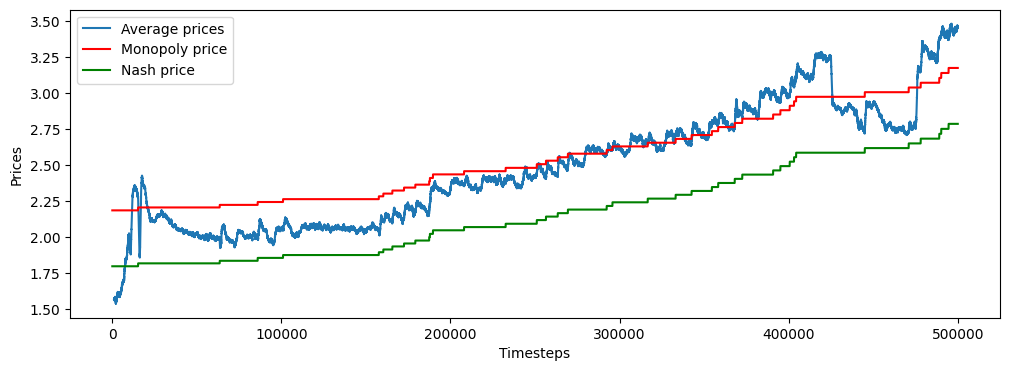

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 4))
plt.plot(df_plot['avg_prices'], label = 'Average prices')
plt.plot(df_plot['p_monopoly'], color = 'red', label = 'Monopoly price')
plt.plot(df_plot['p_nash'], color = 'green', label = 'Nash price')
plt.xlabel('Timesteps')
plt.ylabel('Prices')
plt.legend()
plt.savefig('plot.png')

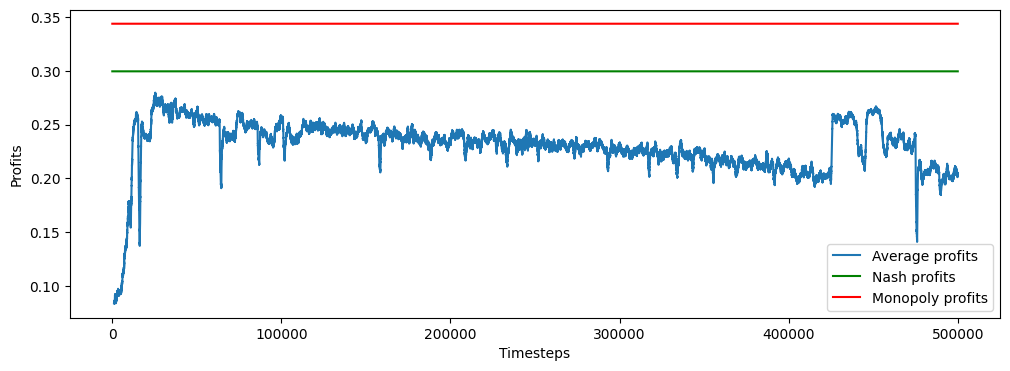

In [47]:
plt.figure(figsize = (12, 4))
plt.plot(df_plot['avg_rewards'], label = 'Average profits')
plt.plot(df_plot['pi_N'], label = 'Nash profits', color = 'green')
plt.plot(df_plot['pi_M'], label = 'Monopoly profits', color = 'red')
plt.xlabel('Timesteps')
plt.ylabel('Profits')
plt.legend()

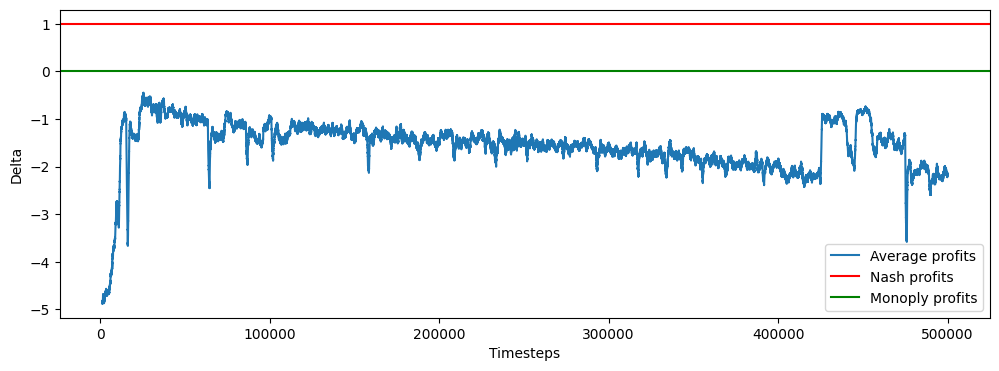

In [48]:
plt.figure(figsize = (12, 4))
plt.plot(df_plot['delta'], label = 'Average profits')
plt.axhline(1, color = 'red', label = 'Nash profits')
plt.axhline(0, color = 'green', label = 'Monoply profits')
plt.xlabel('Timesteps')
plt.ylabel('Delta')
plt.legend()

In [41]:
import pandas as pd
import numpy as np

df  = pd.read_csv('test.csv', sep = ';')
df = df.iloc[100000:105000]
df['rewards_0'] = df['rewards_0'].replace(0, np.nan)
df['rewards_1'] = df['rewards_1'].replace(0, np.nan)

df = df.dropna()
df

,costs,pi_N,pi_M,delta,p_nash,p_monopoly,A,actions_0,prices_0,quantities_0,rewards_0,actions_1,prices_1,quantities_1,rewards_1
100001,1.058081,0.299471,0.343706,0.252653,1.857552,2.245492,2.058081,0.390163,1.883729,0.504660,0.416672,0.694395,2.527533,0.139251,0.204622
100003,1.058081,0.299471,0.343706,0.759172,1.857552,2.245492,2.058081,0.592659,2.312243,0.221716,0.278067,0.447589,2.005251,0.409681,0.388038
100004,1.058081,0.299471,0.343706,0.932981,1.857552,2.245492,2.058081,0.631356,2.394132,0.227312,0.303701,0.545054,2.211503,0.327531,0.377781
100006,1.058081,0.299471,0.343706,0.495046,1.857552,2.245492,2.058081,0.593969,2.315016,0.201879,0.253749,0.399059,1.902554,0.460629,0.388989
100007,1.058081,0.299471,0.343706,0.264775,1.857552,2.245492,2.058081,0.831098,2.816818,0.097314,0.171149,0.464675,2.041407,0.458868,0.451217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,1.077891,0.299471,0.343706,0.416262,1.877362,2.265302,2.077891,0.489539,2.133230,0.418758,0.441932,0.792380,2.786088,0.113474,0.193837
104996,1.077891,0.299471,0.343706,0.031663,1.877362,2.265302,2.077891,0.615089,2.403887,0.306677,0.406653,0.864350,2.941241,0.104699,0.195090
104997,1.077891,0.299471,0.343706,-2.885486,1.877362,2.265302,2.077891,0.275021,1.670776,0.305514,0.181135,0.134835,1.368564,0.559150,0.162530
104998,1.077891,0.299471,0.343706,-3.294363,1.877362,2.265302,2.077891,0.169026,1.442275,0.427235,0.155678,0.155480,1.413071,0.452932,0.151814


In [42]:
df = df.rolling(1000).mean().dropna()
df = df[['prices_0', 'p_nash', 'p_monopoly', 'rewards_0', 'pi_N', 'pi_M']]
df.head()

,prices_0,p_nash,p_monopoly,rewards_0,pi_N,pi_M
101129,2.119045,1.860266,2.248206,0.273457,0.299471,0.343706
101130,2.118483,1.860285,2.248226,0.273217,0.299471,0.343706
101131,2.118794,1.860305,2.248246,0.273112,0.299471,0.343706
101132,2.118541,1.860325,2.248265,0.273215,0.299471,0.343706
101134,2.118457,1.860345,2.248285,0.273234,0.299471,0.343706


In [23]:
prices_0

NameError: name 'prices_0' is not defined